In [17]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [18]:
torch.__version__

'2.4.0'

In [19]:
device = torch.device("cuda")
device

device(type='cuda')

In [20]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [21]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [22]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [23]:
words[:10]

['ah may the devil take you and evewybody were the last words rostov',
 'receptions now hardly let a day go by without having an evening party',
 '',
 '',
 'noticed that he was pale and that his jaw quivered and shook as if in an',
 '',
 'pierre felt unable to disappoint him every day he said to himself one',
 'if i have time answered nicholas but i promised the arkharovs they',
 'dolokhov looked round but did not say anything nor did the mocking',
 'depressing and unsolved problem']

In [24]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [25]:
block_size = 8 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [26]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 8]), torch.int64, torch.Size([204978]), torch.int64)

In [27]:
emb_dim = 32
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[-0.1380, -0.5756,  0.6409,  ...,  1.1823, -0.2692, -0.6081],
        [-0.8553,  0.8270, -0.3022,  ...,  1.3728,  0.1062, -1.3615],
        [-3.0446, -1.8880,  0.5818,  ...,  1.3783,  0.9960,  1.8499],
        ...,
        [-2.0222, -1.4460, -0.1587,  ...,  1.3616,  2.4433, -0.5791],
        [ 0.8567, -0.8249, -0.3699,  ..., -0.7143, -0.8703,  0.5768],
        [ 0.1876, -1.5119, -0.3484,  ...,  0.6776,  0.7389, -0.2423]],
       requires_grad=True)

In [28]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.tanh(self.lin1(x))
        x = self.lin2(x)
        return x 
    


In [29]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 512).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 11:53:21.397000 133821179995968 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/2313360188.py line 8 
W1027 11:53:21.397000 133821179995968 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 11:53:21.397000 133821179995968 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 11:53:21.397000 133821179995968 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 11:53:21.397000 133821179995968 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 11:53:21.397000 133821179995968 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 11:53:21.397000 133821179995968 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 11:53:21.397000 133821179995968 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 angrybut suppress opportunities fuel familyi defend francis preventing podgy assiduity uncles impure mashkas alley tearing honorably evening avenge rage ironically abyss portable brook glittering meddling quick learning schmidt impression appeal neck abbe leads theory arising thunder indolent mourning slipping benefits sunday plastered thiswant mended resembles batteries drying person monsieur naked interrupted supple intimately speaking regimenthe flared charges reinforce bothering side saying reprovingly resulting voyez expect lodgewere croats modeling jolting extreme despair sigh broadbacked torture melting privilege age irregularity honor tornado call attend reddening attraction il brothers quahtehmasteh seconds auerspergs outweigh mysteriously animal wagged milky satisfying rising crawled comedy whirled sunk
 alimony unaltered placed program disaster posterity youturn delirious written conscientiously plait sounds soiree poisoned sustained achievement complacently certainly serve

In [30]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 32])
_orig_mod.lin1.weight torch.Size([512, 256])
_orig_mod.lin1.bias torch.Size([512])
_orig_mod.lin2.weight torch.Size([11189, 512])
_orig_mod.lin2.bias torch.Size([11189])


In [31]:
len(stoi)

11189

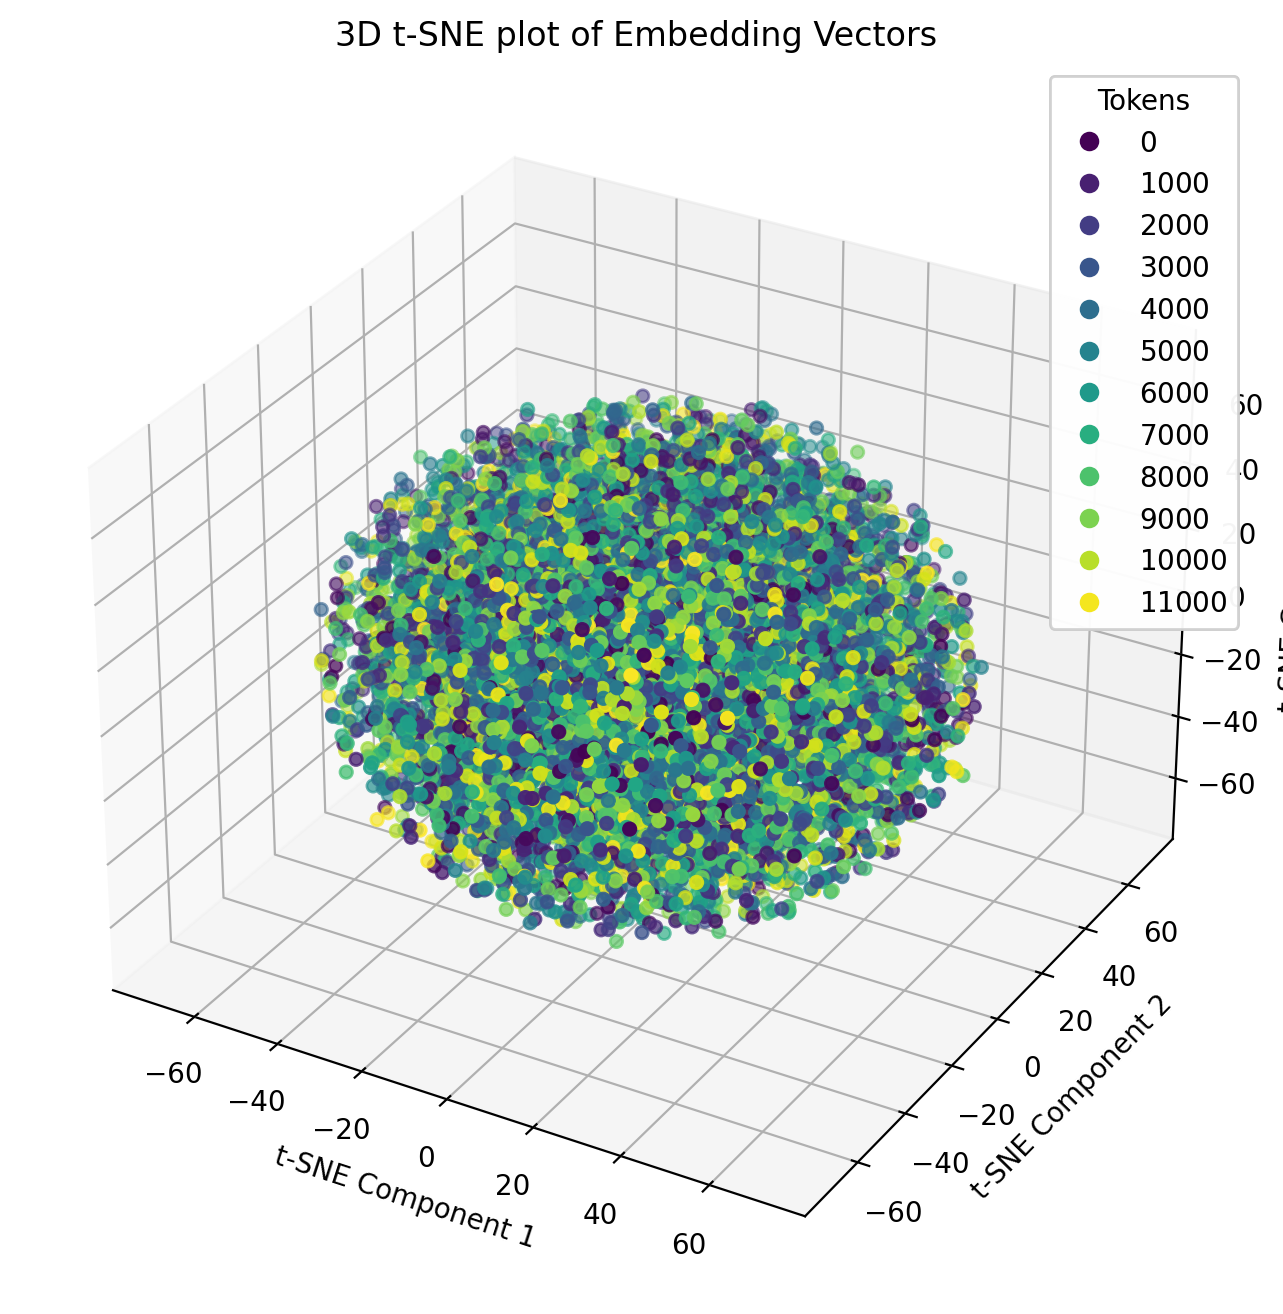

In [32]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [38]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(500):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 2.712320327758789
Epoch 10, Loss: 2.6598904132843018
Epoch 20, Loss: 2.6323494911193848
Epoch 30, Loss: 2.6086180210113525
Epoch 40, Loss: 2.587212085723877
Epoch 50, Loss: 2.5674901008605957
Epoch 60, Loss: 2.549093246459961
Epoch 70, Loss: 2.5317916870117188
Epoch 80, Loss: 2.515443801879883
Epoch 90, Loss: 2.499959945678711
Epoch 100, Loss: 2.485258102416992
Epoch 110, Loss: 2.471285343170166
Epoch 120, Loss: 2.457988739013672
Epoch 130, Loss: 2.44529128074646
Epoch 140, Loss: 2.433189868927002
Epoch 150, Loss: 2.4216508865356445
Epoch 160, Loss: 2.4106483459472656
Epoch 170, Loss: 2.4001235961914062
Epoch 180, Loss: 2.390048027038574
Epoch 190, Loss: 2.380423069000244
Epoch 200, Loss: 2.3712239265441895
Epoch 210, Loss: 2.3624258041381836
Epoch 220, Loss: 2.354001998901367
Epoch 230, Loss: 2.3459386825561523
Epoch 240, Loss: 2.3382151126861572
Epoch 250, Loss: 2.3307952880859375
Epoch 260, Loss: 2.323698043823242
Epoch 270, Loss: 2.316897392272949
Epoch 280, Loss: 2.

In [39]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 
 and it is only i tell you know but i must you see friend
 thought that would be splendid fine driven heavens je by the
 could be seen at this moment coldly prince
 man in the duties here circles of the
 of the convalescence at madam natasha that when the
 
 when did anyone distinctly called to make ones occupied and our
 armchairs make way her father remember her own confusion and in still
 drew through and merged with silver and looking at him in a courier


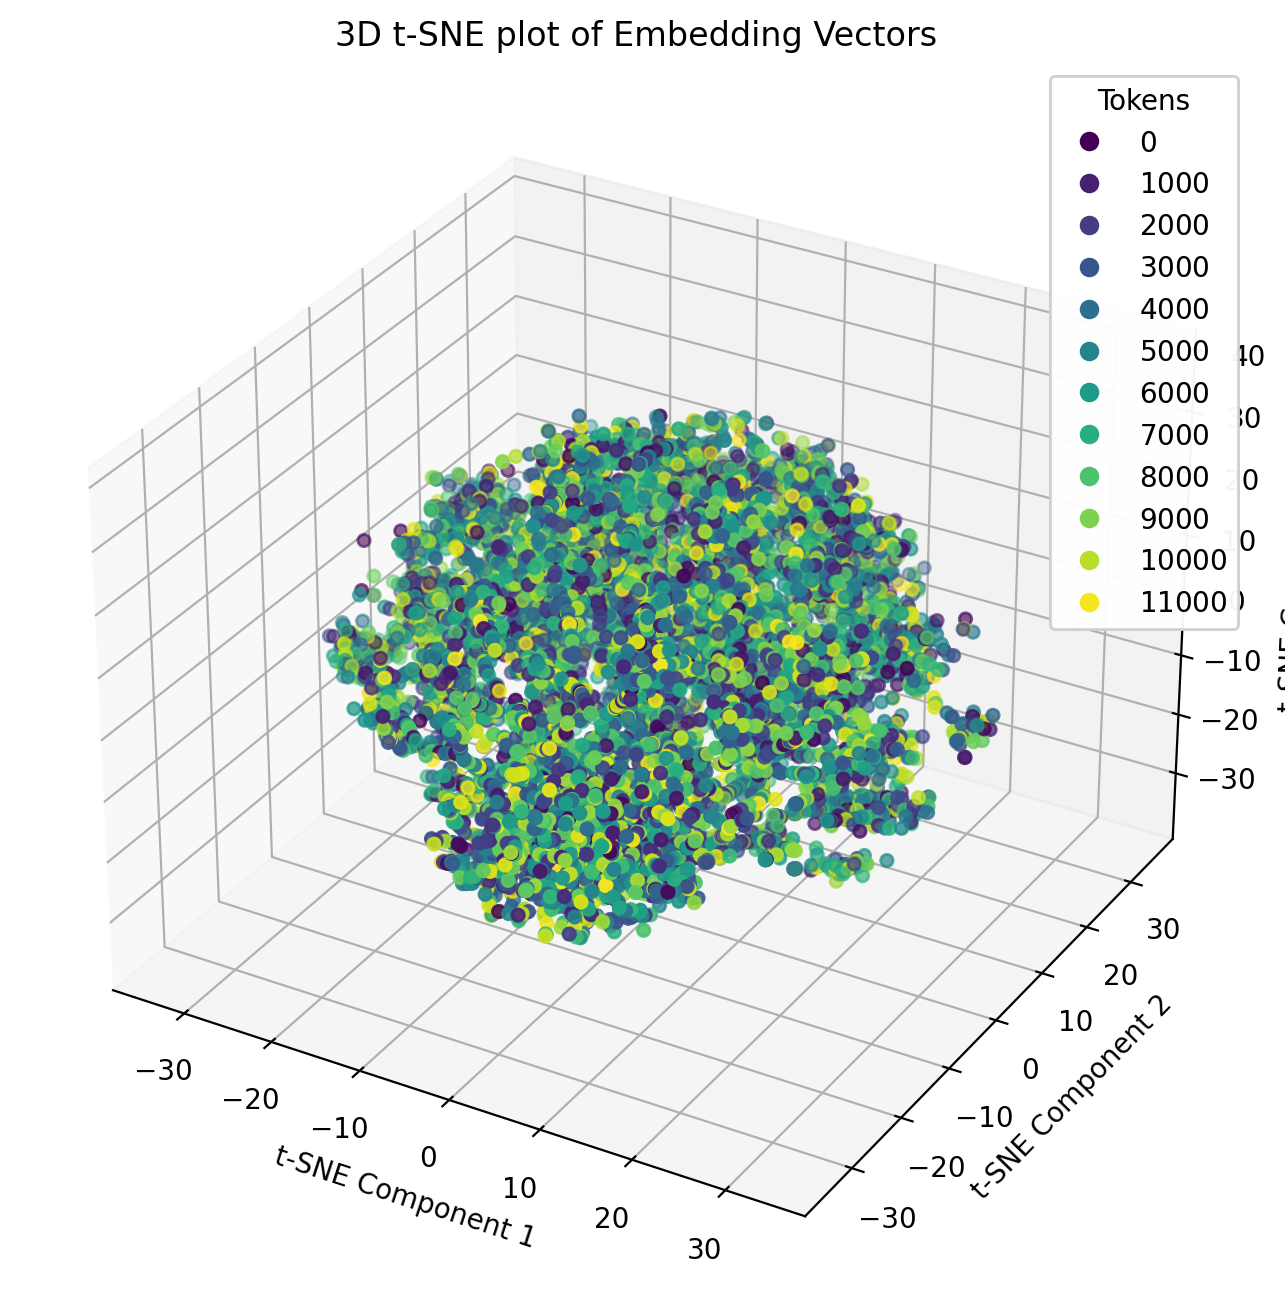

In [40]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [41]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_8_32_512_r.pth")

In [42]:
model = model.to(device)